In [149]:
import pandas as pd
from ISLP import load_data
from lifelines import \
    (KaplanMeierFitter,
     CoxPHFitter)
from lifelines.statistics import \
    (logrank_test, )
from matplotlib.pyplot import subplots

In [150]:
BrainCancer = load_data("BrainCancer")
BrainCancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int64   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int64   
 7   time       88 non-null     float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 3.8 KB


In [151]:
BrainCancer["sex"].value_counts()

sex
Female    45
Male      43
Name: count, dtype: int64

In [152]:
BrainCancer["diagnosis"].value_counts()

diagnosis
Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: count, dtype: int64

In [153]:
BrainCancer["status"].value_counts()

status
0    53
1    35
Name: count, dtype: int64

<Axes: xlabel='timeline'>

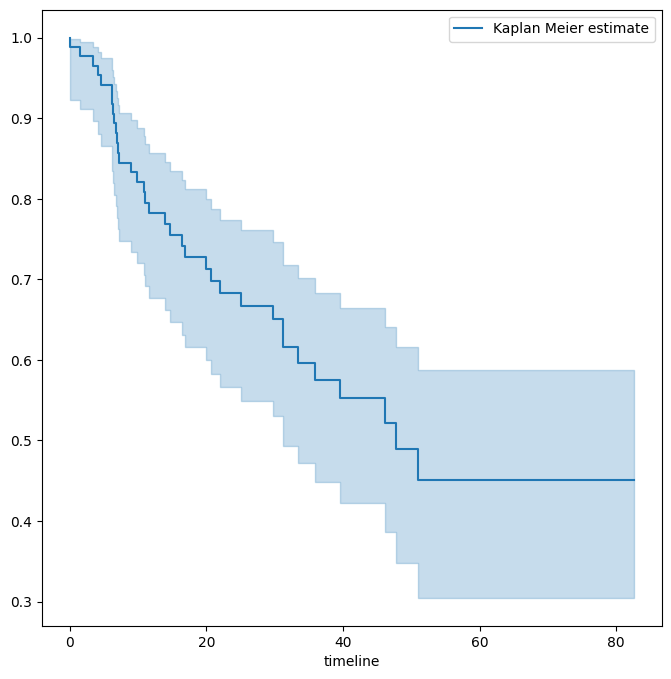

In [154]:
fig, ax = subplots(figsize=(8, 8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer["time"], BrainCancer["status"])
km_brain.plot(label="Kaplan Meier estimate", ax=ax)

In [155]:
km_brain.survival_function_at_times(20)

20    0.713191
Name: KM_estimate, dtype: float64

sex='Female'
sex='Male'


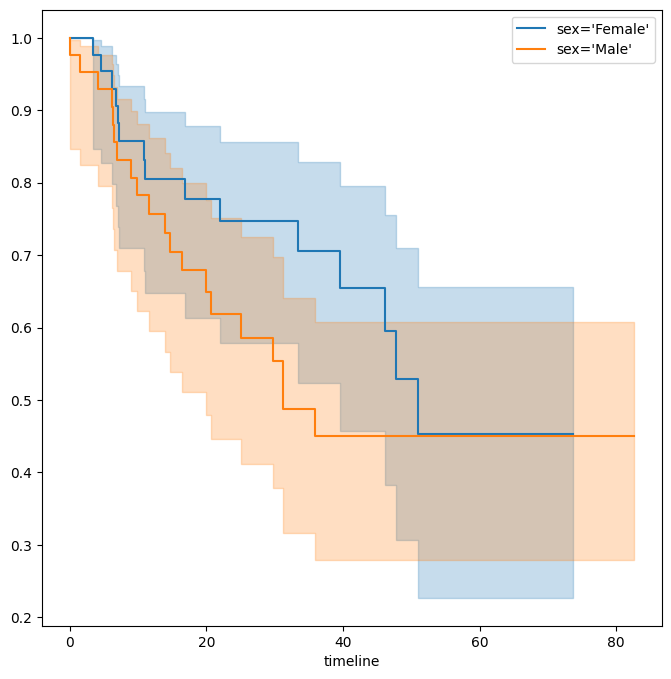

In [156]:
fig, ax = subplots(figsize=(8, 8))
by_sex = {}
for sex, df in BrainCancer.groupby("sex", observed=True):
    print(f"{sex=}")
    by_sex[sex] = df
    km_sex = km.fit(df["time"], df["status"])
    km_sex.plot(label=f"{sex=}", ax=ax)

In [157]:
logrank_test(
    by_sex["Male"]["time"],
    by_sex["Female"]["time"],
    by_sex["Male"]["status"],
    by_sex["Female"]["status"]
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [158]:
sex_df = BrainCancer[["time", "status"]]
# model_df = MS(["time", "status", "sex"], intercept=False).fit_transform(sex_df)
# model_df.info()

sex_male = pd.get_dummies(BrainCancer[["sex"]]).drop(columns=["sex_Female"]).astype(float)
sex_df = pd.concat([sex_df, sex_male], axis=1)
sex_df.rename({"sex_Male": "sex[Male]"}, axis=1, inplace=True)
sex_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       88 non-null     float64
 1   status     88 non-null     int64  
 2   sex[Male]  88 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.2 KB


In [159]:
cox = CoxPHFitter().fit(sex_df, "time", "status")
cox.summary[["coef", "se(coef)", "p"]]

,coef,se(coef),p
covariate,,,
sex[Male],0.407668,0.342004,0.233262


In [160]:
cox.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [161]:
cleaned_ds = BrainCancer.dropna()
cleaned_ds = pd.get_dummies(cleaned_ds)
cleaned_ds.drop(columns=["sex_Female", "diagnosis_HG glioma", "loc_Infratentorial", "stereo_SRS"], inplace=True)

for col in cleaned_ds.columns.values[cleaned_ds.dtypes == bool]:
    cleaned_ds[col] = cleaned_ds[col].astype(float)

cleaned_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 87
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ki                    87 non-null     int64  
 1   gtv                   87 non-null     float64
 2   status                87 non-null     int64  
 3   time                  87 non-null     float64
 4   sex_Male              87 non-null     float64
 5   diagnosis_LG glioma   87 non-null     float64
 6   diagnosis_Meningioma  87 non-null     float64
 7   diagnosis_Other       87 non-null     float64
 8   loc_Supratentorial    87 non-null     float64
 9   stereo_SRT            87 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 7.5 KB


In [162]:
cox_all = CoxPHFitter().fit(cleaned_ds, "time", "status")
cox_all.summary[["coef", "se(coef)", "p"]]

,coef,se(coef),p
covariate,,,
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
sex_Male,0.183748,0.360358,0.610119
diagnosis_LG glioma,-1.239530,0.579555,0.032455
diagnosis_Meningioma,-2.154566,0.450524,0.000002
diagnosis_Other,-1.268870,0.617672,0.039949
loc_Supratentorial,0.441195,0.703669,0.530665
stereo_SRT,0.177778,0.601578,0.767597


In [163]:
def representative(series):
    if hasattr(series.dtype , 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()

modal_data = BrainCancer.dropna().apply(representative, axis=0)
# modal_data = cleaned_ds.apply(representative, axis=0)
modal_data

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


In [164]:
levels = BrainCancer["diagnosis"].dropna().unique()
levels

['Meningioma', 'HG glioma', 'LG glioma', 'Other']
Categories (4, object): ['HG glioma', 'LG glioma', 'Meningioma', 'Other']

In [165]:

modal_df = pd.DataFrame([modal_data.iloc[0] for _ in range(len(levels))])
modal_df["diagnosis"] = levels
modal_df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,HG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,LG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,Other,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


In [166]:
cleaned_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 87
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ki                    87 non-null     int64  
 1   gtv                   87 non-null     float64
 2   status                87 non-null     int64  
 3   time                  87 non-null     float64
 4   sex_Male              87 non-null     float64
 5   diagnosis_LG glioma   87 non-null     float64
 6   diagnosis_Meningioma  87 non-null     float64
 7   diagnosis_Other       87 non-null     float64
 8   loc_Supratentorial    87 non-null     float64
 9   stereo_SRT            87 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 9.5 KB


In [167]:
modal_X = pd.DataFrame(columns=cleaned_ds.columns)

for col in ["ki", "gtv", "time"]:
    modal_X[col] = [modal_data[col].iloc[0] for _ in range(len(levels))]

for col in ["sex_Male", "loc_Supratentorial", "stereo_SRT"]:
    [original_col, cat] = col.split("_")
    print(f"{original_col=}, {cat=}")
    value = float(modal_data[original_col].iloc[0] == cat)
    modal_X[col] = [value for _ in range(len(levels))]

for i in range(len(levels)):
    col = f"diagnosis_{levels[i]}"
    if col in modal_X.columns:
        modal_X[col] = 0.
        modal_X.loc[i, col] = 1.

modal_X["status"] = [pd.Series.mode(cleaned_ds["status"]).iloc[0] for _ in range(len(levels))]

modal_X.info()

original_col='sex', cat='Male'
original_col='loc', cat='Supratentorial'
original_col='stereo', cat='SRT'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ki                    4 non-null      float64
 1   gtv                   4 non-null      float64
 2   status                4 non-null      int64  
 3   time                  4 non-null      float64
 4   sex_Male              4 non-null      float64
 5   diagnosis_LG glioma   4 non-null      float64
 6   diagnosis_Meningioma  4 non-null      float64
 7   diagnosis_Other       4 non-null      float64
 8   loc_Supratentorial    4 non-null      float64
 9   stereo_SRT            4 non-null      float64
dtypes: float64(9), int64(1)
memory usage: 452.0 bytes


In [168]:
modal_X

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,80.91954,8.687011,0,27.188621,0.0,0.0,1.0,0.0,1.0,1.0
1,80.91954,8.687011,0,27.188621,0.0,0.0,0.0,0.0,1.0,1.0
2,80.91954,8.687011,0,27.188621,0.0,1.0,0.0,0.0,1.0,1.0
3,80.91954,8.687011,0,27.188621,0.0,0.0,0.0,1.0,1.0,1.0


In [169]:
predicted_survival = cox_all.predict_survival_function(modal_X)
predicted_survival

,0,1,2,3
0.07,0.997947,0.982430,0.994881,0.995029
1.18,0.997947,0.982430,0.994881,0.995029
1.41,0.995679,0.963342,0.989245,0.989555
1.54,0.995679,0.963342,0.989245,0.989555
2.03,0.995679,0.963342,0.989245,0.989555
...,...,...,...,...
65.02,0.688772,0.040136,0.394181,0.404936
67.38,0.688772,0.040136,0.394181,0.404936
73.74,0.688772,0.040136,0.394181,0.404936
78.75,0.688772,0.040136,0.394181,0.404936


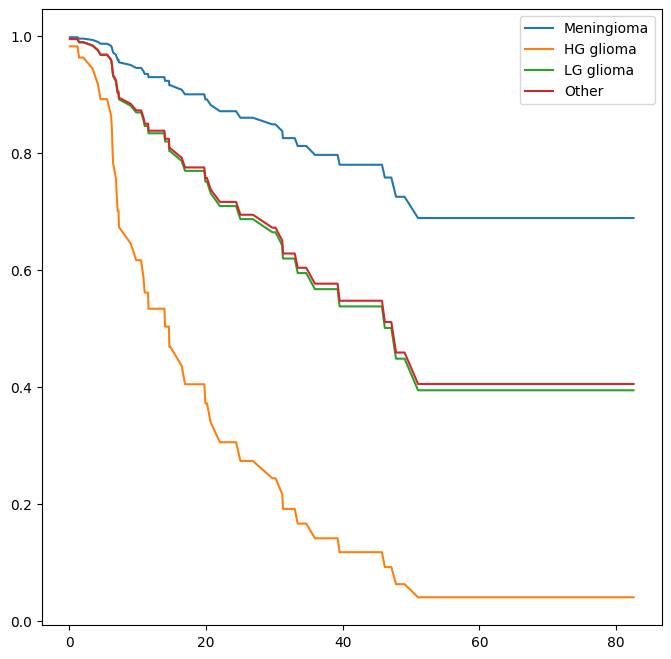

In [170]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax)
ax.legend(levels);